# 1.Setup

### 1.1 Import

In [1]:
#-------------------------------------------import-------------------------------------------
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

#import tensorflow dependencies (API)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Conv2D, MaxPooling2D, Input, Flatten
import tensorflow as tf

import uuid # to generate unique image id

#### FOR LATER USE !! Face DETECTION.xml File

In [2]:
# Link to download : https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

face_cascade = cv2.CascadeClassifier('C:/Users/Mohamed Amine/Desktop/Face Detection/haarcascade_frontalface_default.xml')

### 1.2 Avoid out of MEMORY errors

In [2]:
# Avoid out of MEMO errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
# List the GPUs present in the computer
for gpu in gpus:
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 1.3 Create paths

In [4]:
#-------------------------------------------create paths-------------------------------------------
# Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [5]:
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

# 2.Collect Pos/Anchors img 

### 2.1 Untar Wild Dataset

#### FOR LATER USE !! Download the negative Dataset

In [7]:
# Labelled Faces in the wild dataset
# Link to Download: http://vis-www.cs.umass.edy/lfw/
# uncompress -CMD (tar -xf "lfw.tgz")

In [8]:
# Move lfw to data/negative repository
#for directory in os.listdir('lfw'):
#    for file in os.listdir(os.path.join('lfw', directory)):
#        EX_PATH = os.path.join('lfw', directory, file)
#        NEW_PATH = os.path.join(NEG_PATH, file)
#        os.replace(EX_PATH, NEW_PATH)

### 2.2 Image Collection

In [8]:
#-------------------------------------------collecting images-------------------------------------------
# Collect pos and anchor classes:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # resize frame
    frame = frame[120:120+250,200:200+250,:]

    # collect anchor im
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(libjames, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    
    # collect positive im
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    
    cv2.imshow('image collection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# 3. Load & Preprocess Images

### 3.1 Get Images Dirs

In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(250)
positive = tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(250)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(250)

In [10]:
# Testing
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\67b6dcd3-b133-11ec-ab3b-80325378d058.jpg'

### 3.2 Preprocessing - Scale & Resize

In [12]:
def preprocess(file_path):
    # Read in img from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the img with Tensor
    img = tf.io.decode_jpeg(byte_img)
    # Prepross steps - resizig the img to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale img between 0 and 1
    img = img / 225.0
    return img

### 3.3 Create Labelled Dataset

In [13]:
# (anchor, positive) >> 1,1,1,1
# (anchor, negative) >> 0,0,0,0

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>


In [15]:
samples = data.as_numpy_iterator()

In [16]:
example = samples.next()

### 3.4 Build Train & Test Partition

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
# biuld dataloader pipline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [19]:
# Training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [20]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

### 4.1 Build Embedding Layer

In [21]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_img')
    # first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64 , (2,2), padding='same')(c2)
    
    # third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # final block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1] , name='embedding')

In [22]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

### 4.2 Build Distance Layer

In [23]:
# Siamese L1 distance class
class L1Dist(Layer):
    # init methot
    def __init__(self, **kwargs):
        super().__init__()
    
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
l1 = L1Dist()

In [25]:
l1

### 4.3 Make Siamese Model

In [25]:
input_img = Input(name='input_img', shape=(100,100,3))

In [26]:
embedding(input_img)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [27]:
def make_siamese_model():
    
    # handle inputs
    input_img = Input(name='input_img', shape=(100,100,3))
    validation_img = Input(name='validation_img', shape=(100,100,3))
    
    # Combine distance component
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_img), embedding(validation_img))
    
    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_img, validation_img], outputs=classifier, name='SiameseNetwork')

In [28]:
siamese_model = make_siamese_model()

In [30]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[1][0]     

# 5. Training

### 5.1 Setup Loss & Optimizer

In [29]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [30]:
opt = tf.keras.optimizers.Adam(1e-4)

### 5.2 Establish Checkpoints

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Build Train Step Function

In [32]:
@tf.function
def train_step(batch):
    # Record All of the operations
    with tf.GradientTape() as tape: 
        # get anchor and pos/neg img
        X = batch[:2]
        # get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

### 5.4 Build Training Loop

In [33]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epochs {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train steps:
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.5 Train the model

In [34]:
EPOCHS = 50

In [35]:
# Train
#train(train_data, EPOCHS)

# 6. Evaluate Model

### 6.1 Import Metrics

In [36]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### 6.2 Make Prediction

In [37]:
# Get a batch of the test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [39]:
# predictions
y_hat = siamese_model.predict([test_input, test_val])
# y_hat

In [41]:
# Post processing the results
[1 if prediction >0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]

In [42]:
y_true

array([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

### 6.3 Calculate Metrics

In [40]:
# Create a metric object
m = Recall()
# Calculate recall val
m.update_state(y_true, y_hat)
# Return recall result
m.result().numpy()

0.0

### 6.4 Viz

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


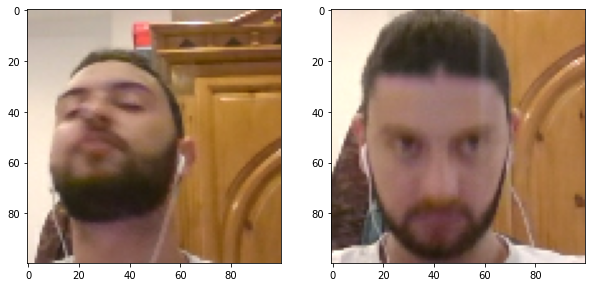

In [44]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

# 7. Save Model

In [45]:
#siamese_model.save("siamesemodel.h5")

In [41]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [49]:
# Make prediction with reloaded model
model.predict([test_input, test_val])

array([[1.0000000e+00],
       [9.9999976e-01],
       [1.0935106e-08],
       [8.5403472e-12],
       [1.0000000e+00],
       [2.8633669e-01],
       [1.0000000e+00],
       [3.5336088e-11],
       [1.2022969e-09],
       [1.0000000e+00],
       [2.0106199e-10],
       [9.9999988e-01],
       [9.9999964e-01],
       [1.5564591e-11],
       [1.6240771e-06],
       [9.9999988e-01]], dtype=float32)

In [50]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

### 8.1 Verification

In [42]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make prediction
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    # Detectin threshold
    detection = np.sum(np.array(results) > detection_threshold)
    # Verification threshold
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

### 8.2 Real Time Verification

In [43]:
# with OpenCV
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    # resize frame
    frame = frame[120:120+250,200:200+250,:]
    
    # Verification trick
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to app_data/inp_img folder:
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.9)
        print(verified)
    
    cv2.imshow('verification', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

True
False


In [53]:
np.sum(np.squeeze(results) > 0.5)

98